In [ ]:
csv 파일 확인

In [6]:
import pandas as pd
import numpy as np

csv_path = "C:/Users/82103/Desktop/multimodal/OHT/oht_merged_output.csv"  # 병합된 CSV 파일 경로
df = pd.read_csv(csv_path)

df.head()

,subset,subfolder,json_filename,bin_filename,device_id,collection_date,collection_time,state,temp_max_value,temp_max_x,...,ex_humidity,ex_illuminance,NTC,PM10,PM2.5,PM1.0,CT1,CT2,CT3,CT4
0,train,1,train\01\oht01_0826_203735.json,oht01_0826_203735.bin,oht01,08-26,20:37:35,0,45.58,130.0,...,36.0,511.0,27.0,20.0,12.0,8.0,2.30,1.35,0.35,0.35
1,train,1,train\01\oht01_0826_203736.json,oht01_0826_203736.bin,oht01,08-26,20:37:36,0,45.56,128.0,...,35.0,514.0,27.0,20.0,12.0,7.0,2.80,0.94,0.64,0.50
2,train,1,train\01\oht01_0826_203737.json,oht01_0826_203737.bin,oht01,08-26,20:37:37,0,45.53,130.0,...,35.0,515.0,27.1,20.0,12.0,8.0,2.86,0.86,0.68,0.48
3,train,1,train\01\oht01_0826_203738.json,oht01_0826_203738.bin,oht01,08-26,20:37:38,0,45.48,128.0,...,35.0,513.0,27.1,21.0,12.0,7.0,2.22,1.18,0.68,0.44
4,train,1,train\01\oht01_0826_203739.json,oht01_0826_203739.bin,oht01,08-26,20:37:39,0,45.43,129.0,...,36.0,523.0,27.1,21.0,11.0,7.0,2.41,1.38,0.60,0.50


In [ ]:
AGV 파일 시계열 실험

C:\Users\82103\anaconda3\envs\tf37\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


검증 데이터 정확도: 0.935471100554236

검증 데이터 분류 리포트:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2584
           1       0.93      0.95      0.94      1088
           2       0.88      0.92      0.90      1050
           3       0.78      0.97      0.87       330

    accuracy                           0.94      5052
   macro avg       0.90      0.94      0.92      5052
weighted avg       0.94      0.94      0.94      5052


테스트 데이터 정확도: 0.9663499604117182

테스트 데이터 분류 리포트:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2724
           1       0.94      0.95      0.94       995
           2       0.93      0.93      0.93      1003
           3       0.93      0.88      0.91       330

    accuracy                           0.97      5052
   macro avg       0.95      0.94      0.94      5052
weighted avg       0.97      0.97      0.97      5052



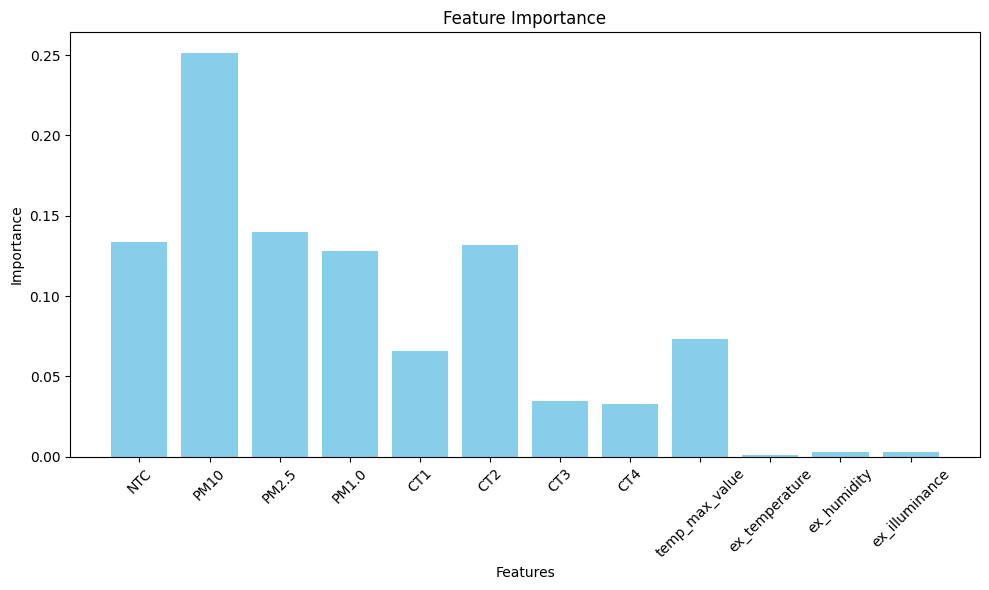

In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# 1. CSV 파일 읽기
csv_path = "C:/Users/82103/Desktop/multimodal/AGV/agv_merged_output.csv"  # 병합된 CSV 파일 경로
df = pd.read_csv(csv_path)

# 2. 데이터 전처리
# 결측값 처리: 숫자형은 평균값으로, 범주형은 최빈값으로 채움
df.fillna(df.mean(), inplace=True)
for col in df.select_dtypes(include="object").columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Label Encoding: 범주형 데이터를 숫자형으로 변환
label_encoder = LabelEncoder()
if "device_id" in df.columns:
    df["device_id"] = label_encoder.fit_transform(df["device_id"])

# 특징 스케일링: 숫자형 열을 정규화
features = ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "temp_max_value", "ex_temperature", "ex_humidity", "ex_illuminance"]
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# 3. 데이터셋 분리: train, test, val
train_df = df[df["subset"] == "train"]
test_df = df[df["subset"] == "test"]
val_df = df[df["subset"] == "val"]

# 학습 데이터
X_train = train_df[features]
y_train = train_df["state"]

# 검증 데이터
X_val = val_df[features]
y_val = val_df["state"]

# 테스트 데이터
X_test = test_df[features]
y_test = test_df["state"]

# 4. 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. 검증 데이터 평가
y_val_pred = model.predict(X_val)
print("검증 데이터 정확도:", accuracy_score(y_val, y_val_pred))
print("\n검증 데이터 분류 리포트:")
print(classification_report(y_val, y_val_pred))

# 6. 테스트 데이터 평가
y_test_pred = model.predict(X_test)
print("\n테스트 데이터 정확도:", accuracy_score(y_test, y_test_pred))
print("\n테스트 데이터 분류 리포트:")
print(classification_report(y_test, y_test_pred))

# 7. 특징 중요도 시각화
feature_importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(features, feature_importances, color="skyblue")
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
AGC 파일 Col 변수에 따른 정확도 실험

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

# 1. CSV 파일 읽기
csv_path = "C:/Users/82103/Desktop/multimodal/AGV/agv_merged_output.csv"  # 병합된 CSV 파일 경로
df = pd.read_csv(csv_path)

# 2. 데이터 전처리
# 결측값 처리: 숫자형은 평균값으로, 범주형은 최빈값으로 채움
df.fillna(df.mean(), inplace=True)
for col in df.select_dtypes(include="object").columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Label Encoding: 범주형 데이터를 숫자형으로 변환
label_encoder = LabelEncoder()
if "device_id" in df.columns:
    df["device_id"] = label_encoder.fit_transform(df["device_id"])

# 특징 스케일링: 숫자형 열을 정규화
all_features = ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", 
                "temp_max_value", "ex_temperature", "ex_humidity", "ex_illuminance"]
scaler = StandardScaler()
df[all_features] = scaler.fit_transform(df[all_features])

# 3. 데이터셋 분리: train, test, val
train_df = df[df["subset"] == "train"]
test_df = df[df["subset"] == "test"]
val_df = df[df["subset"] == "val"]

# 학습 데이터
X_train_full = train_df[all_features]
y_train = train_df["state"]

# 검증 데이터
X_val_full = val_df[all_features]
y_val = val_df["state"]

# 테스트 데이터
X_test_full = test_df[all_features]
y_test = test_df["state"]

# 4. 변수 조합별 모델 학습 및 평가
feature_combinations = [
    ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4"], 
    ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "temp_max_value"],
    ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "temp_max_value", "ex_temperature"],
    ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "temp_max_value", "ex_humidity"],
     ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "temp_max_value", "ex_illuminance"],
    ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "ex_temperature", "ex_humidity", "ex_illuminance"],
    all_features  # 모든 변수 포함
]

results = []

for features in feature_combinations:
    # 학습 데이터 설정
    X_train = train_df[features]
    X_val = val_df[features]
    X_test = test_df[features]

    # 모델 학습
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # 검증 데이터 평가
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # 테스트 데이터 평가
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # 결과 저장
    results.append({
        "Features": features,
        "Validation Accuracy": val_accuracy,
        "Test Accuracy": test_accuracy
    })

# 5. 결과 출력
for i, result in enumerate(results, 1):
    print(f"Combination {i}:")
    print(f"Features: {result['Features']}")
    print(f"Validation Accuracy: {result['Validation Accuracy']:.4f}")
    print(f"Test Accuracy: {result['Test Accuracy']:.4f}")
    print("-" * 40)


C:\Users\82103\anaconda3\envs\tf37\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  del sys.path[0]


Combination 1:
Features: ['NTC', 'PM10', 'PM2.5', 'PM1.0', 'CT1', 'CT2', 'CT3', 'CT4']
Validation Accuracy: 0.9327
Test Accuracy: 0.9703
----------------------------------------
Combination 2:
Features: ['NTC', 'PM10', 'PM2.5', 'PM1.0', 'CT1', 'CT2', 'CT3', 'CT4', 'temp_max_value']
Validation Accuracy: 0.9331
Test Accuracy: 0.9665
----------------------------------------
Combination 3:
Features: ['NTC', 'PM10', 'PM2.5', 'PM1.0', 'CT1', 'CT2', 'CT3', 'CT4', 'temp_max_value', 'ex_temperature']
Validation Accuracy: 0.9341
Test Accuracy: 0.9675
----------------------------------------
Combination 4:
Features: ['NTC', 'PM10', 'PM2.5', 'PM1.0', 'CT1', 'CT2', 'CT3', 'CT4', 'temp_max_value', 'ex_humidity']
Validation Accuracy: 0.9333
Test Accuracy: 0.9644
----------------------------------------
Combination 5:
Features: ['NTC', 'PM10', 'PM2.5', 'PM1.0', 'CT1', 'CT2', 'CT3', 'CT4', 'temp_max_value', 'ex_illuminance']
Validation Accuracy: 0.9341
Test Accuracy: 0.9640
----------------------------

In [ ]:
OHT 실험

C:\Users\82103\anaconda3\envs\tf37\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


검증 데이터 정확도: 0.952873876327976

검증 데이터 분류 리포트:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3059
           1       0.92      0.93      0.92      1804
           2       0.94      0.96      0.95      1819
           3       0.94      0.95      0.95       660

    accuracy                           0.95      7342
   macro avg       0.95      0.95      0.95      7342
weighted avg       0.95      0.95      0.95      7342


테스트 데이터 정확도: 0.957504767093435

테스트 데이터 분류 리포트:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3265
           1       0.92      0.95      0.93      1706
           2       0.94      0.97      0.95      1711
           3       0.97      0.91      0.94       660

    accuracy                           0.96      7342
   macro avg       0.95      0.95      0.95      7342
weighted avg       0.96      0.96      0.96      7342



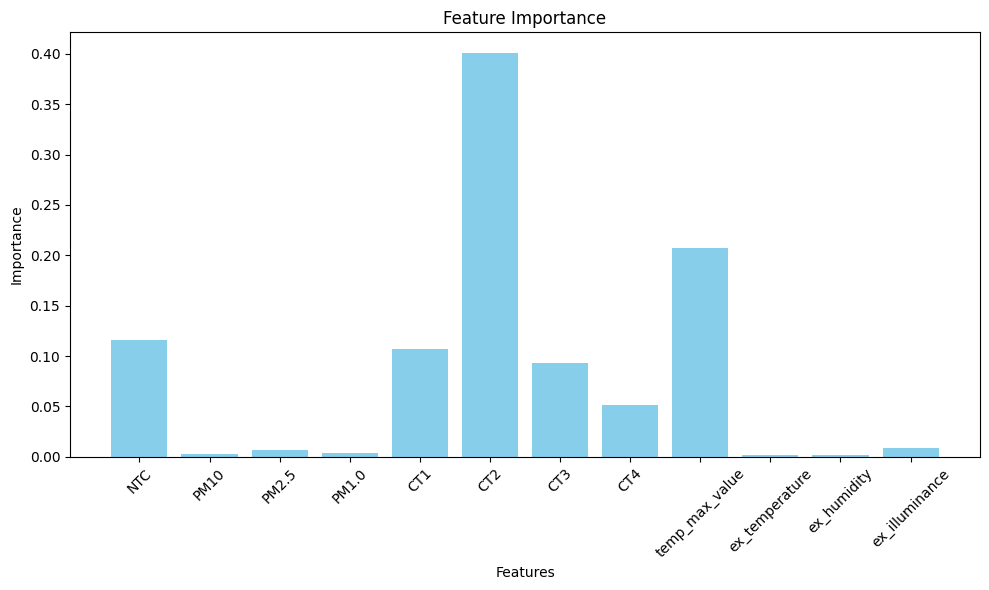

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# 1. CSV 파일 읽기
csv_path = "C:/Users/82103/Desktop/multimodal/OHT/oht_merged_output.csv"  # 병합된 CSV 파일 경로
df = pd.read_csv(csv_path)

# 2. 데이터 전처리
# 결측값 처리: 숫자형은 평균값으로, 범주형은 최빈값으로 채움
df.fillna(df.mean(), inplace=True)
for col in df.select_dtypes(include="object").columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Label Encoding: 범주형 데이터를 숫자형으로 변환
label_encoder = LabelEncoder()
if "device_id" in df.columns:
    df["device_id"] = label_encoder.fit_transform(df["device_id"])

# 특징 스케일링: 숫자형 열을 정규화
features = ['NTC', 'PM10', 'PM2.5', 'PM1.0', 'CT1', 'CT2', 'CT3', 'CT4', 'temp_max_value', 'ex_temperature', 'ex_humidity', 'ex_illuminance']
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# 3. 데이터셋 분리: train, test, val
train_df = df[df["subset"] == "train"]
test_df = df[df["subset"] == "test"]
val_df = df[df["subset"] == "val"]

# 학습 데이터
X_train = train_df[features]
y_train = train_df["state"]

# 검증 데이터
X_val = val_df[features]
y_val = val_df["state"]

# 테스트 데이터
X_test = test_df[features]
y_test = test_df["state"]

# 4. 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. 검증 데이터 평가
y_val_pred = model.predict(X_val)
print("검증 데이터 정확도:", accuracy_score(y_val, y_val_pred))
print("\n검증 데이터 분류 리포트:")
print(classification_report(y_val, y_val_pred))

# 6. 테스트 데이터 평가
y_test_pred = model.predict(X_test)
print("\n테스트 데이터 정확도:", accuracy_score(y_test, y_test_pred))
print("\n테스트 데이터 분류 리포트:")
print(classification_report(y_test, y_test_pred))

# 7. 특징 중요도 시각화
feature_importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(features, feature_importances, color="skyblue")
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

# 1. CSV 파일 읽기
csv_path = "C:/Users/82103/Desktop/multimodal/OHT/oht_merged_output.csv"  # 병합된 CSV 파일 경로
df = pd.read_csv(csv_path)

# 2. 데이터 전처리
# 결측값 처리: 숫자형은 평균값으로, 범주형은 최빈값으로 채움
df.fillna(df.mean(), inplace=True)
for col in df.select_dtypes(include="object").columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Label Encoding: 범주형 데이터를 숫자형으로 변환
label_encoder = LabelEncoder()
if "device_id" in df.columns:
    df["device_id"] = label_encoder.fit_transform(df["device_id"])

# 특징 스케일링: 숫자형 열을 정규화
all_features = ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", 
                "temp_max_value", "ex_temperature", "ex_humidity", "ex_illuminance"]
scaler = StandardScaler()
df[all_features] = scaler.fit_transform(df[all_features])

# 3. 데이터셋 분리: train, test, val
train_df = df[df["subset"] == "train"]
test_df = df[df["subset"] == "test"]
val_df = df[df["subset"] == "val"]

# 학습 데이터
X_train_full = train_df[all_features]
y_train = train_df["state"]

# 검증 데이터
X_val_full = val_df[all_features]
y_val = val_df["state"]

# 테스트 데이터
X_test_full = test_df[all_features]
y_test = test_df["state"]

# 4. 변수 조합별 모델 학습 및 평가
feature_combinations = [
    ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4"], 
    ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "temp_max_value"],
    ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "temp_max_value", "ex_temperature"],
    ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "temp_max_value", "ex_humidity"],
     ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "temp_max_value", "ex_illuminance"],
    ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "ex_temperature", "ex_humidity", "ex_illuminance"],
    all_features  # 모든 변수 포함
]

results = []

for features in feature_combinations:
    # 학습 데이터 설정
    X_train = train_df[features]
    X_val = val_df[features]
    X_test = test_df[features]

    # 모델 학습
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # 검증 데이터 평가
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # 테스트 데이터 평가
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # 결과 저장
    results.append({
        "Features": features,
        "Validation Accuracy": val_accuracy,
        "Test Accuracy": test_accuracy
    })

# 5. 결과 출력
for i, result in enumerate(results, 1):
    print(f"Combination {i}:")
    print(f"Features: {result['Features']}")
    print(f"Validation Accuracy: {result['Validation Accuracy']:.4f}")
    print(f"Test Accuracy: {result['Test Accuracy']:.4f}")
    print("-" * 40)


C:\Users\82103\anaconda3\envs\tf37\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  del sys.path[0]


Combination 1:
Features: ['NTC', 'PM10', 'PM2.5', 'PM1.0', 'CT1', 'CT2', 'CT3', 'CT4']
Validation Accuracy: 0.9361
Test Accuracy: 0.9452
----------------------------------------
Combination 2:
Features: ['NTC', 'PM10', 'PM2.5', 'PM1.0', 'CT1', 'CT2', 'CT3', 'CT4', 'temp_max_value']
Validation Accuracy: 0.9523
Test Accuracy: 0.9559
----------------------------------------
Combination 3:
Features: ['NTC', 'PM10', 'PM2.5', 'PM1.0', 'CT1', 'CT2', 'CT3', 'CT4', 'temp_max_value', 'ex_temperature']
Validation Accuracy: 0.9531
Test Accuracy: 0.9580
----------------------------------------
Combination 4:
Features: ['NTC', 'PM10', 'PM2.5', 'PM1.0', 'CT1', 'CT2', 'CT3', 'CT4', 'temp_max_value', 'ex_humidity']
Validation Accuracy: 0.9538
Test Accuracy: 0.9568
----------------------------------------
Combination 5:
Features: ['NTC', 'PM10', 'PM2.5', 'PM1.0', 'CT1', 'CT2', 'CT3', 'CT4', 'temp_max_value', 'ex_illuminance']
Validation Accuracy: 0.9537
Test Accuracy: 0.9572
----------------------------

In [ ]:
AGV OHT 통합 테스트

In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

# 1. CSV 파일 읽기
oht_csv_path = "C:/Users/82103/Desktop/multimodal/OHT/oht_merged_output.csv"  # OHT 파일 경로
agv_csv_path = "C:/Users/82103/Desktop/multimodal/AGV/agv_merged_output.csv"  # AGV 파일 경로

oht_df = pd.read_csv(oht_csv_path)
agv_df = pd.read_csv(agv_csv_path)

# 2. 데이터 병합
df = pd.concat([oht_df, agv_df], ignore_index=True)

# 3. 데이터 전처리
# 결측값 처리: 숫자형은 평균값으로, 범주형은 최빈값으로 채움
df.fillna(df.mean(), inplace=True)
for col in df.select_dtypes(include="object").columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Label Encoding: 범주형 데이터를 숫자형으로 변환
label_encoder = LabelEncoder()
if "device_id" in df.columns:
    df["device_id"] = label_encoder.fit_transform(df["device_id"])

# 특징 스케일링: 숫자형 열을 정규화
all_features = ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", 
                "temp_max_value", "ex_temperature", "ex_humidity", "ex_illuminance"]
scaler = StandardScaler()
df[all_features] = scaler.fit_transform(df[all_features])

# 4. 데이터셋 분리: train, test, val
train_df = df[df["subset"] == "train"]
test_df = df[df["subset"] == "test"]
val_df = df[df["subset"] == "val"]

# 학습 데이터
X_train_full = train_df[all_features]
y_train = train_df["state"]

# 검증 데이터
X_val_full = val_df[all_features]
y_val = val_df["state"]

# 테스트 데이터
X_test_full = test_df[all_features]
y_test = test_df["state"]

# 5. 변수 조합별 모델 학습 및 평가
feature_combinations = [
    ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4"], 
    ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "temp_max_value"],
    ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "temp_max_value", "ex_temperature"],
    ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "temp_max_value", "ex_humidity"],
    ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "temp_max_value", "ex_illuminance"],
    ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "ex_temperature", "ex_humidity", "ex_illuminance"],
    all_features  # 모든 변수 포함
]

results = []

for features in feature_combinations:
    # 학습 데이터 설정
    X_train = train_df[features]
    X_val = val_df[features]
    X_test = test_df[features]

    # 모델 학습
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # 검증 데이터 평가
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # 테스트 데이터 평가
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # 결과 저장
    results.append({
        "Features": features,
        "Validation Accuracy": val_accuracy,
        "Test Accuracy": test_accuracy
    })

# 6. 결과 출력
for i, result in enumerate(results, 1):
    print(f"Combination {i}:")
    print(f"Features: {result['Features']}")
    print(f"Validation Accuracy: {result['Validation Accuracy']:.4f}")
    print(f"Test Accuracy: {result['Test Accuracy']:.4f}")
    print("-" * 40)


C:\Users\82103\anaconda3\envs\tf37\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Combination 1:
Features: ['NTC', 'PM10', 'PM2.5', 'PM1.0', 'CT1', 'CT2', 'CT3', 'CT4']
Validation Accuracy: 0.9346
Test Accuracy: 0.9528
----------------------------------------
Combination 2:
Features: ['NTC', 'PM10', 'PM2.5', 'PM1.0', 'CT1', 'CT2', 'CT3', 'CT4', 'temp_max_value']
Validation Accuracy: 0.9459
Test Accuracy: 0.9545
----------------------------------------
Combination 3:
Features: ['NTC', 'PM10', 'PM2.5', 'PM1.0', 'CT1', 'CT2', 'CT3', 'CT4', 'temp_max_value', 'ex_temperature']
Validation Accuracy: 0.9469
Test Accuracy: 0.9580
----------------------------------------
Combination 4:
Features: ['NTC', 'PM10', 'PM2.5', 'PM1.0', 'CT1', 'CT2', 'CT3', 'CT4', 'temp_max_value', 'ex_humidity']
Validation Accuracy: 0.9467
Test Accuracy: 0.9593
----------------------------------------
Combination 5:
Features: ['NTC', 'PM10', 'PM2.5', 'PM1.0', 'CT1', 'CT2', 'CT3', 'CT4', 'temp_max_value', 'ex_illuminance']
Validation Accuracy: 0.9450
Test Accuracy: 0.9612
----------------------------